## 1.Project Introduction

The objective of this case study is to predict the health insurance cost incurred by Individuals based on their age, gender, BMI, number of children, smoking habit and geo-location.

本案例研究的目的是根据年龄，性别，BMI，儿童数量，吸烟习惯和地理位置来预测个人承担的健康保险费用。

- Features available are:

    - sex: insurance contractor gender, female, male

    - bmi: Body mass index (ideally 18.5 to 24.9)

    - children: Number of children covered by health insurance / Number of dependents

    - smoker: smoking habits

    - region: the beneficiary's residential area in the US, northeast, southeast, southwest, northwest.

    - charges: Individual medical costs billed by health insurance


Data Source:https://www.kaggle.com/mirichoi0218/insurance

## 2.Load the Dataset and Libraries

In [4]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/insurance/insurance.csv


In [5]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt


from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import r2_score,mean_squared_error
from sklearn.ensemble import RandomForestRegressor

In [6]:
df = pd.read_csv("/kaggle/input/insurance/insurance.csv")

In [7]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [8]:
df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [9]:
df.isnull().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [10]:
# convert categorical variable to numerical

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()

# sex
le.fit(df.sex.drop_duplicates())
df.sex = le.transform(df.sex)

# smoke
le.fit(df.smoker.drop_duplicates())
df.smoker = le.transform(df.smoker)

In [11]:
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,0,27.900,0,1,southwest,16884.92400
1,18,1,33.770,1,0,southeast,1725.55230
2,28,1,33.000,3,0,southeast,4449.46200
3,33,1,22.705,0,0,northwest,21984.47061
4,32,1,28.880,0,0,northwest,3866.85520


In [12]:
# Check unique values in 'region' column
df['region'].unique()

array(['southwest', 'southeast', 'northwest', 'northeast'], dtype=object)

In [13]:
region_dummies = pd.get_dummies(df['region'], drop_first = True)
region_dummies.head()

,northwest,southeast,southwest
0,0,0,1
1,0,1,0
2,0,1,0
3,1,0,0
4,1,0,0


In [14]:
df = pd.concat([df, region_dummies], axis = 1)

In [15]:
df.drop(['region'], axis = 1, inplace = True)

In [16]:
df.head()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
0,19,0,27.900,0,1,16884.92400,0,0,1
1,18,1,33.770,1,0,1725.55230,0,1,0
2,28,1,33.000,3,0,4449.46200,0,1,0
3,33,1,22.705,0,0,21984.47061,1,0,0
4,32,1,28.880,0,0,3866.85520,1,0,0


## 3.Exploratory Data Analysis

In [17]:
# Check NA values
df.isnull().sum()

age          0
sex          0
bmi          0
children     0
smoker       0
charges      0
northwest    0
southeast    0
southwest    0
dtype: int64

In [18]:
# Check the DataFrame Info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        1338 non-null   int64  
 1   sex        1338 non-null   int64  
 2   bmi        1338 non-null   float64
 3   children   1338 non-null   int64  
 4   smoker     1338 non-null   int64  
 5   charges    1338 non-null   float64
 6   northwest  1338 non-null   uint8  
 7   southeast  1338 non-null   uint8  
 8   southwest  1338 non-null   uint8  
dtypes: float64(2), int64(4), uint8(3)
memory usage: 66.8 KB


The people in the southeast have the highest insurance charges and obviously, with the highest BMI index.

In [19]:
## group by region

In [20]:
# Group the Age to see the relationship between age and charges
df_age = df.groupby(by = 'age').mean()
df_age

,sex,bmi,children,smoker,charges,northwest,southeast,southwest
age,,,,,,,,
18,0.521739,31.326159,0.449275,0.173913,7086.217556,0.000000,0.536232,0.000000
19,0.514706,28.596912,0.426471,0.264706,9747.909335,0.500000,0.044118,0.455882
20,0.517241,30.632759,0.862069,0.310345,10159.697736,0.241379,0.275862,0.275862
21,0.535714,28.185714,0.785714,0.071429,4730.464330,0.250000,0.250000,0.250000
22,0.535714,31.087679,0.714286,0.214286,10012.932802,0.250000,0.285714,0.214286
23,0.500000,31.454464,1.000000,0.250000,12419.820040,0.250000,0.250000,0.250000
24,0.500000,29.142679,0.464286,0.214286,10648.015962,0.250000,0.250000,0.250000
25,0.535714,29.693929,1.285714,0.178571,9838.365311,0.250000,0.250000,0.250000
26,0.535714,29.428929,1.071429,0.107143,6133.825309,0.250000,0.250000,0.250000


We can get a basic idea that the charges will increase when the age increase.

plot analysis

In [21]:
df.describe()

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
count,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,0.505232,30.663397,1.094918,0.204783,13270.422265,0.242900,0.272048,0.242900
std,14.049960,0.500160,6.098187,1.205493,0.403694,12110.011237,0.428995,0.445181,0.428995
min,18.000000,0.000000,15.960000,0.000000,0.000000,1121.873900,0.000000,0.000000,0.000000
25%,27.000000,0.000000,26.296250,0.000000,0.000000,4740.287150,0.000000,0.000000,0.000000
50%,39.000000,1.000000,30.400000,1.000000,0.000000,9382.033000,0.000000,0.000000,0.000000
75%,51.000000,1.000000,34.693750,2.000000,0.000000,16639.912515,0.000000,1.000000,0.000000
max,64.000000,1.000000,53.130000,5.000000,1.000000,63770.428010,1.000000,1.000000,1.000000


## 4.Visualzie the dataset

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f08f6fb6cd0>,
      dtype=object)

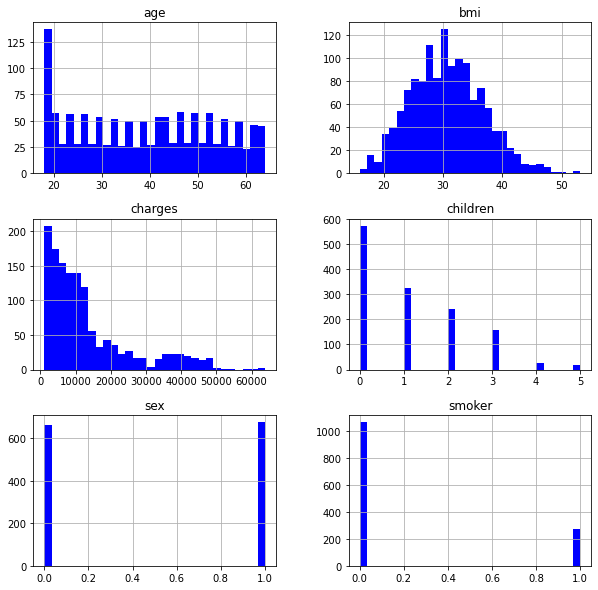

In [22]:
df[['age', 'sex', 'bmi', 'children', 'smoker', 'charges']].hist(bins = 30, figsize = (10,10), color = 'blue')

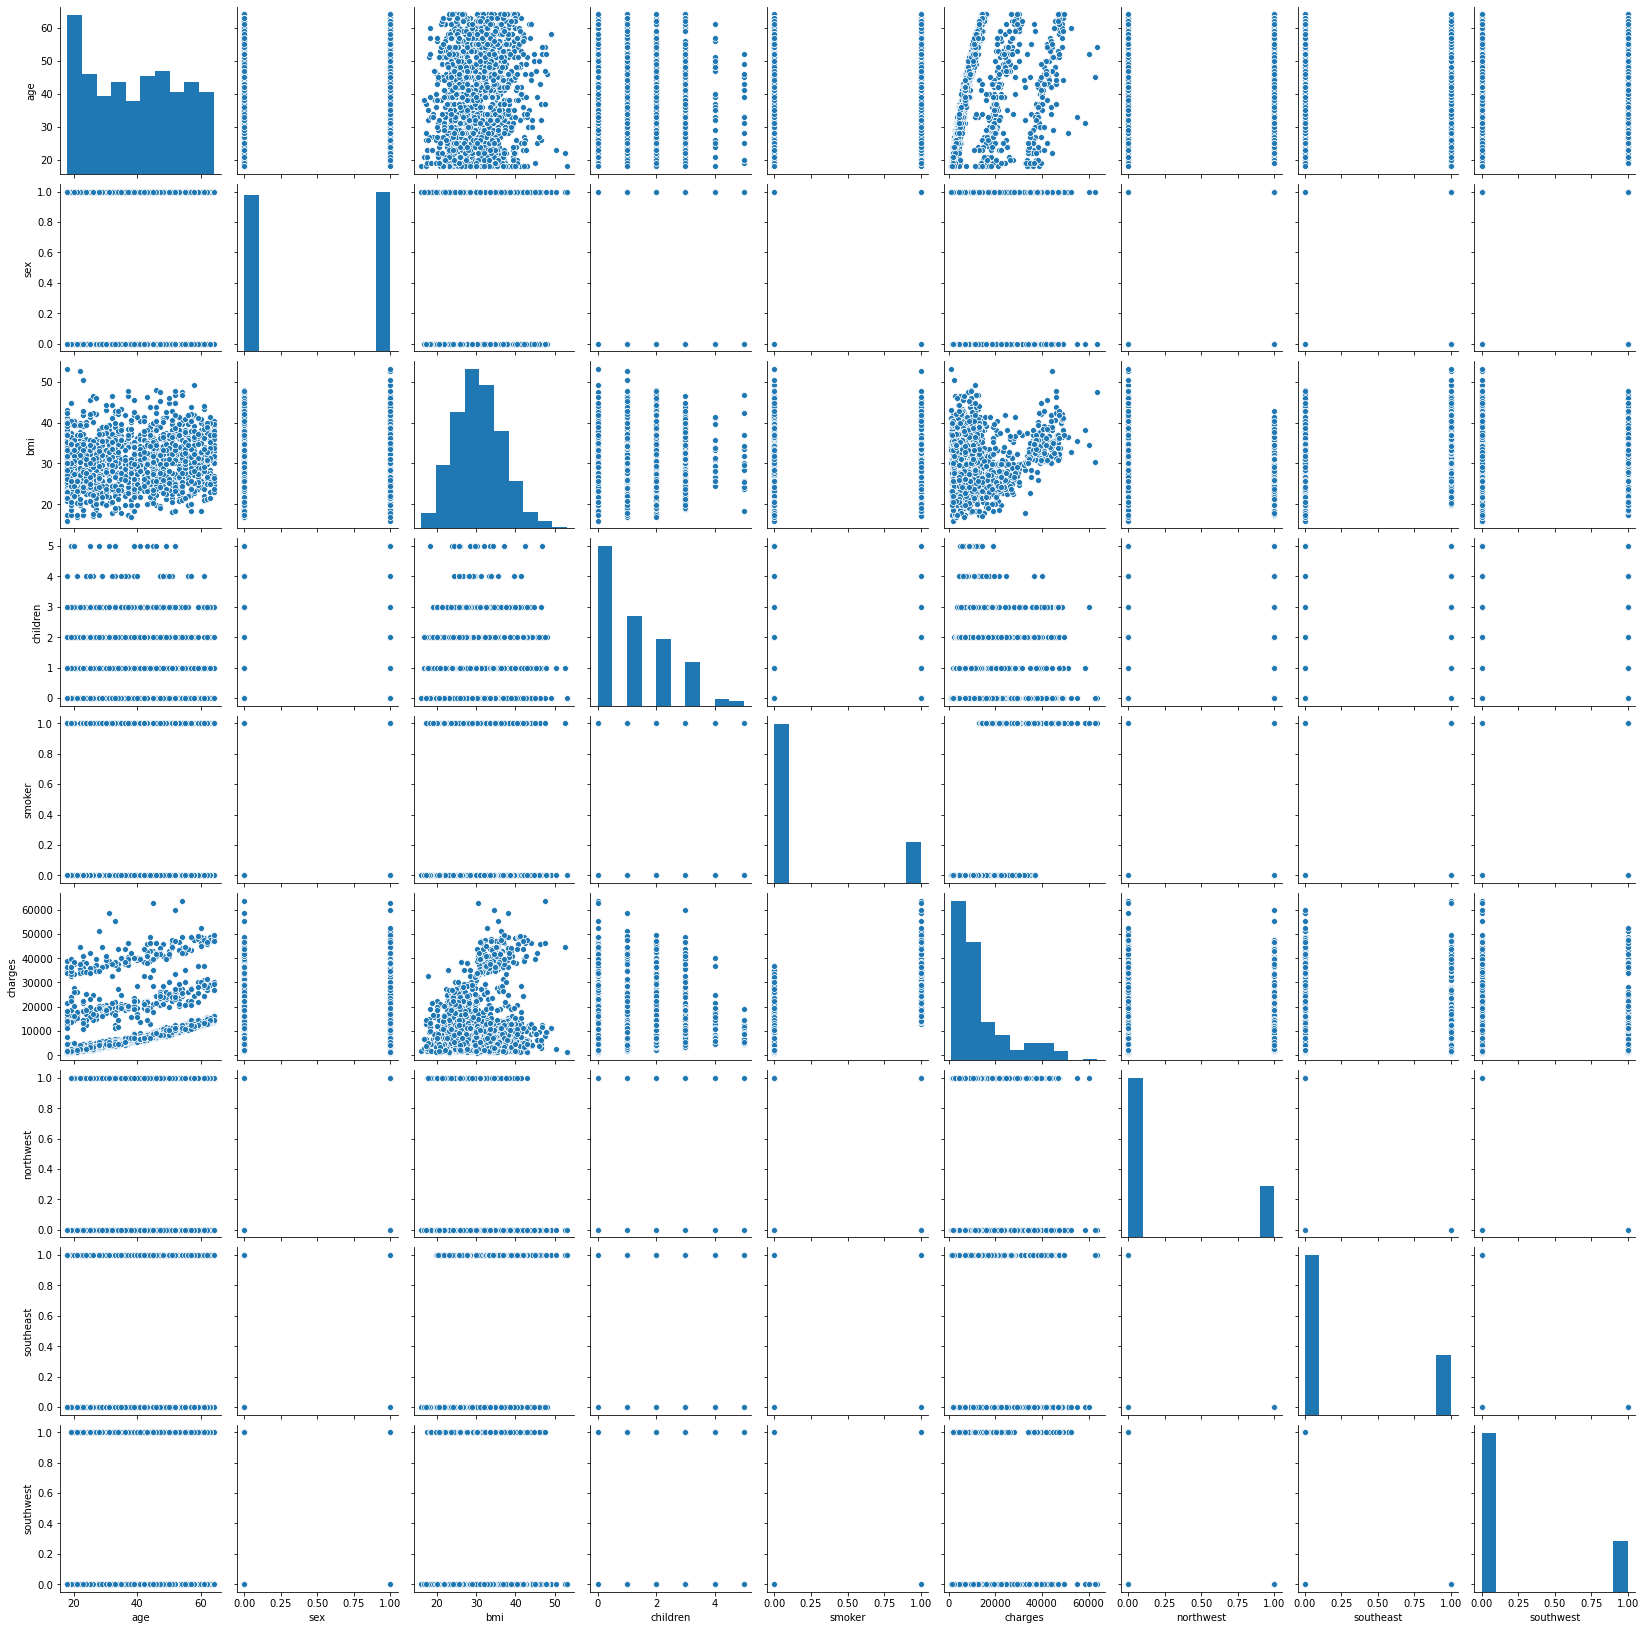

In [23]:
#plot pairplot
sns.pairplot(df)

Check the realtionship between the age and Charges, we can see the it is more complex than a linear relationship.

So we will consider some non-linear Algorithim such as ANN or XgBoost.

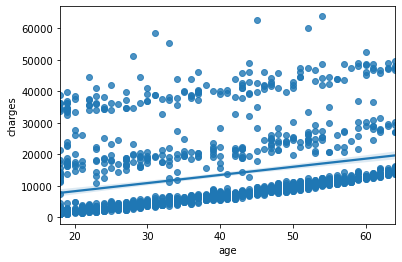

In [24]:
# Explore the relation between age and charges
sns.regplot(x = 'age', y = 'charges', data = df)
plt.show()

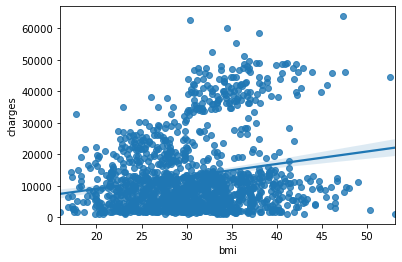

In [25]:
# Explore the relation between BMI and charges
sns.regplot(x = 'bmi', y = 'charges', data = df)
plt.show()

In [26]:
# Check the correlation
corr = df.corr()
corr

,age,sex,bmi,children,smoker,charges,northwest,southeast,southwest
age,1.000000,-0.020856,0.109272,0.042469,-0.025019,0.299008,-0.000407,-0.011642,0.010016
sex,-0.020856,1.000000,0.046371,0.017163,0.076185,0.057292,-0.011156,0.017117,-0.004184
bmi,0.109272,0.046371,1.000000,0.012759,0.003750,0.198341,-0.135996,0.270025,-0.006205
children,0.042469,0.017163,0.012759,1.000000,0.007673,0.067998,0.024806,-0.023066,0.021914
smoker,-0.025019,0.076185,0.003750,0.007673,1.000000,0.787251,-0.036945,0.068498,-0.036945
charges,0.299008,0.057292,0.198341,0.067998,0.787251,1.000000,-0.039905,0.073982,-0.043210
northwest,-0.000407,-0.011156,-0.135996,0.024806,-0.036945,-0.039905,1.000000,-0.346265,-0.320829
southeast,-0.011642,0.017117,0.270025,-0.023066,0.068498,0.073982,-0.346265,1.000000,-0.346265
southwest,0.010016,-0.004184,-0.006205,0.021914,-0.036945,-0.043210,-0.320829,-0.346265,1.000000


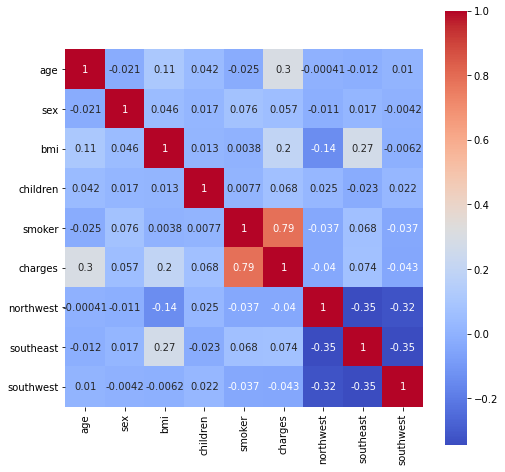

In [27]:
plt.figure(figsize=(8,8))
p = sns.heatmap(df.corr(),cmap="coolwarm",annot=True, square =True)

Smoke have the most positive relationship with the charges

## 5.Split the train test dataset

In [28]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'charges', 'northwest',
       'southeast', 'southwest'],
      dtype='object')

In [29]:
X = df.drop(['charges'], axis = 1)
y = df.charges

In [30]:
X = np.array(X).astype('float32')
y = np.array(y).astype('float32')

In [31]:
y_reshape = y.reshape(-1,1)

In [32]:
from sklearn.preprocessing import StandardScaler

scaler_x = StandardScaler()
X_scale = scaler_x.fit_transform(X)

scaler_y = StandardScaler()
y_scale = scaler_y.fit_transform(y_reshape)

In [33]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_scale,y_scale,test_size = 0.2,random_state = 42)

In [34]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(1070, 8)
(268, 8)
(1070, 1)
(268, 1)


## 6.Linear Regression Model

In [35]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, mean_absolute_error,accuracy_score
from math import sqrt

lr = LinearRegression()
lr.fit(X_train, y_train)

lr_R2 = lr.score(X_test,y_test)
lr_R2

0.783592984238872

In [36]:
# Predict the value
y_pred = lr.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [37]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

RMSE = 5796.284 
MSE = 33596910.0 
MAE = 4181.194 
R2= 0.7835930056134655 
Adjusted R2 = 0.7777666634569049


## 7.Multiple linear regression (Degree = 2)

In [38]:
quad = PolynomialFeatures (degree = 2)
X_quad = quad.fit_transform(X_scale)

X_train_plr,X_test_plr,y_train_plr,y_test_plr = train_test_split(X_quad,y_scale,test_size = 0.2, random_state = 0)

plr = LinearRegression().fit(X_train_plr,y_train_plr)

plr_R2 = plr.score(X_test_plr,y_test_plr)
plr_R2

0.8798806486099952

In [39]:
# Predict the value
y_pred = plr.predict(X_test_plr)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test_plr)

In [40]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

RMSE = 4372.023 
MSE = 19114588.0 
MAE = 2952.615 
R2= 0.8798806536062128 
Adjusted R2 = 0.8766466712033032


## 8.Deep Learning Model (ANN)

In [41]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, Activation, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [42]:
ANN_model = keras.Sequential()
ANN_model.add(Dense(50, input_dim = 8))
ANN_model.add(Activation('relu'))

ANN_model.add(Dense(180))
ANN_model.add(Activation('relu'))
ANN_model.add(Dropout(0.3))

ANN_model.add(Dense(180))
ANN_model.add(Activation('relu'))
ANN_model.add(Dropout(0.3))

ANN_model.add(Dense(50))
ANN_model.add(Activation('linear'))

ANN_model.add(Dense(1))
ANN_model.compile(loss = 'mse', optimizer = 'adam')
ANN_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                450       
_________________________________________________________________
activation (Activation)      (None, 50)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 180)               9180      
_________________________________________________________________
activation_1 (Activation)    (None, 180)               0         
_________________________________________________________________
dropout (Dropout)            (None, 180)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 180)               32580     
_________________________________________________________________
activation_2 (Activation)    (None, 180)               0

In [43]:
# Compile the model and trainning
ANN_model.compile(optimizer= 'Adam', loss='mean_squared_error')
epochs_hist = ANN_model.fit(X_train, y_train, epochs= 50, batch_size = 20, validation_split= 0.2)

result = ANN_model.evaluate(X_test, y_test)
accuracy_ANN = 1 - result
print('Accuracy : {}'.format(accuracy_ANN) )

Epoch 1/50
43/43 [==============================] - 0s 9ms/step - loss: 0.4879 - val_loss: 0.2355
Epoch 2/50
43/43 [==============================] - 0s 4ms/step - loss: 0.2464 - val_loss: 0.1723
Epoch 3/50
43/43 [==============================] - 0s 4ms/step - loss: 0.2197 - val_loss: 0.1674
Epoch 4/50
43/43 [==============================] - 0s 4ms/step - loss: 0.2017 - val_loss: 0.1615
Epoch 5/50
43/43 [==============================] - 0s 4ms/step - loss: 0.1981 - val_loss: 0.1603
Epoch 6/50
43/43 [==============================] - 0s 4ms/step - loss: 0.1980 - val_loss: 0.1840
Epoch 7/50
43/43 [==============================] - 0s 4ms/step - loss: 0.1826 - val_loss: 0.1645
Epoch 8/50
43/43 [==============================] - 0s 4ms/step - loss: 0.1896 - val_loss: 0.1514
Epoch 9/50
43/43 [==============================] - 0s 3ms/step - loss: 0.1911 - val_loss: 0.1943
Epoch 10/50
43/43 [==============================] - 0s 4ms/step - loss: 0.1862 - val_loss: 0.1888
Epoch 11/50
43/43 [

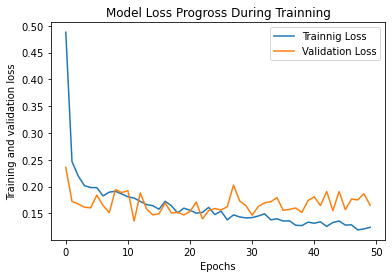

In [44]:
epochs_hist.history.keys()
plt.plot(epochs_hist.history['loss'])
plt.plot(epochs_hist.history['val_loss'])
plt.title('Model Loss Progross During Trainning')
plt.xlabel('Epochs')
plt.ylabel('Training and validation loss')
plt.legend(['Trainnig Loss','Validation Loss'])

Text(0, 0.5, 'True Values')

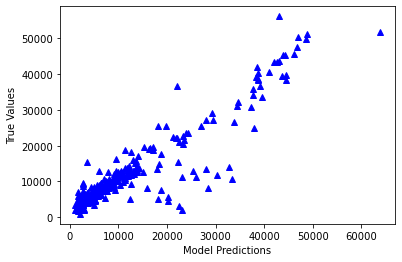

In [45]:
# change the color
y_pred = ANN_model.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

plt.plot(y_test_orig, y_pred_orig, "^", color = 'b')
plt.xlabel('Model Predictions')
plt.ylabel('True Values')

In [46]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

RMSE = 4872.678 
MSE = 23742986.0 
MAE = 2854.98 
R2= 0.8470648683593497 
Adjusted R2 = 0.8429473840459476


## 9.Random Forest

In [47]:
from sklearn.model_selection import GridSearchCV
# Create the parameter grid based on the results of random search 
param_grid = {
    'bootstrap': [True],
    'max_depth': [4, 5, 6, 7],
    'max_features': [2, 3, 4],
    'min_samples_leaf': [2, 3, 4],
    'min_samples_split': [3, 4, 5],
    'n_estimators': [10, 30, 50, 100]
}

# Create a based model
rf = RandomForestRegressor(criterion = 'mse')

# Instantiate the grid search model
grid_search_rf = GridSearchCV(estimator = rf, param_grid = param_grid, 
                          cv = 5, n_jobs = -1, verbose = 4)

In [48]:
grid_search_rf.fit(X_train, y_train)

grid_search_rf.best_params_

Fitting 5 folds for each of 432 candidates, totalling 2160 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    2.1s
[Parallel(n_jobs=-1)]: Done  90 tasks      | elapsed:    5.1s
[Parallel(n_jobs=-1)]: Done 213 tasks      | elapsed:   10.5s
[Parallel(n_jobs=-1)]: Done 384 tasks      | elapsed:   18.3s
[Parallel(n_jobs=-1)]: Done 605 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 874 tasks      | elapsed:   40.4s
[Parallel(n_jobs=-1)]: Done 1193 tasks      | elapsed:   55.0s
[Parallel(n_jobs=-1)]: Done 1560 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 1977 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 2160 out of 2160 | elapsed:  1.7min finished
/opt/conda/lib/python3.7/site-packages/sklearn/model_selection/_search.py:765: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  self.best_estimator_.fit(X, y, **fit_params)


{'bootstrap': True,
 'max_depth': 6,
 'max_features': 4,
 'min_samples_leaf': 2,
 'min_samples_split': 4,
 'n_estimators': 100}

In [49]:
grid_search_rf_R2 = grid_search_rf.score(X_test,y_test)
grid_search_rf_R2

0.876510822791174

In [50]:
# Predict the value
y_pred = grid_search_rf.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [51]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

RMSE = 4378.531 
MSE = 19171537.42512941 
MAE = 2575.6028845366814 
R2= 0.8765108311180179 
Adjusted R2 = 0.8731861227250415


## 10.XGBoost

In [52]:
#! pip install xgboost
import xgboost as xgb

In [53]:
param_grid = {
        'gamma': [0.1,0.3, 0.5, 1],   # regularization parameter 
        'subsample': [0.6, 0.8, 1.0], # % of rows taken to build each tree
        'colsample_bytree': [0.6, 0.8, 1.0], # number of columns used by each tree
        'max_depth': [3, 4, 5], # depth of each tree
        'n_estimaters': [10, 30, 50, 100],
        'learning_rate' :[0.01, 0.03, 0.05]
        }

In [54]:
xgb_model = xgb.XGBRegressor(objective = 'reg:squarederror')

grid_xgb = GridSearchCV(xgb_model,
                    param_grid,
                    cv = 5, 
                    n_jobs = -1, 
                    verbose = 4)

In [55]:
grid_xgb.fit(X_train, y_train)

grid_xgb.best_params_

Fitting 5 folds for each of 1296 candidates, totalling 6480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  17 tasks      | elapsed:    1.8s
[Parallel(n_jobs=-1)]: Done 148 tasks      | elapsed:    4.6s
[Parallel(n_jobs=-1)]: Done 394 tasks      | elapsed:   10.1s
[Parallel(n_jobs=-1)]: Done 736 tasks      | elapsed:   17.9s
[Parallel(n_jobs=-1)]: Done 1178 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 1716 tasks      | elapsed:   39.4s
[Parallel(n_jobs=-1)]: Done 2354 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 3088 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 3922 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 4852 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 5882 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 6480 out of 6480 | elapsed:  2.8min finished


[17:04:41] WARNING: /workspace/src/learner.cc:480: 
Parameters: { n_estimaters } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.




{'colsample_bytree': 1.0,
 'gamma': 0.1,
 'learning_rate': 0.05,
 'max_depth': 3,
 'n_estimaters': 10,
 'subsample': 0.6}

In [56]:
grid_xgb_R2 = grid_xgb.score(X_test,y_test)
grid_xgb_R2

0.880884719042577

In [57]:
# Predict the value
y_pred = grid_xgb.predict(X_test)

y_pred_orig = scaler_y.inverse_transform(y_pred)
y_test_orig = scaler_y.inverse_transform(y_test)

In [58]:
k = X_test.shape[1]
n = len(X_test)

RMSE = float(format(np.sqrt(mean_squared_error(y_test_orig, y_pred_orig)),'.3f'))
MSE = mean_squared_error(y_test_orig, y_pred_orig)
MAE = mean_absolute_error(y_test_orig, y_pred_orig)
r2 = r2_score(y_test_orig, y_pred_orig)
adj_r2 = 1 - (1-r2) * (n-1)/(n-k)

print('RMSE =',RMSE, 
      '\nMSE =',MSE, 
      '\nMAE =',MAE,
      '\nR2=',r2, 
      '\nAdjusted R2 =',adj_r2)

RMSE = 4300.29 
MSE = 18492496.0 
MAE = 2489.5288 
R2= 0.8808847238110471 
Adjusted R2 = 0.8776777740674984


## 11.Summary
Compare the MSE between Linear Regression, Random Forest, Artificial Neural Network and XGBoost tuned by Grid Search, the best model is XGBoost with the lowest MSE and highest R-squared value of 0.881.